# Norman analysis

In [1]:
import warnings
import os
import sys
import gc
import warnings

In [2]:
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import rapids_singlecell as rsc
import numpy as np
import scanpy as sc
import pandas as pd
import scipy
import numpy as np
import tqdm
import scipy.stats

sys.path.append("/home/icb/kemal.inecik/work/codes/tardis")
import tardis
tardis.config = tardis.config_server

print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: True


In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [1046]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    adata_file_path = os.path.join(tardis.config.io_directories["processed"], "cpa_Norman2019_prep_new.h5ad")
    assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
    adata = ad.read_h5ad(adata_file_path)
    adata.X = adata.layers["counts"].copy()
    del adata.layers
    gc.collect()
adata

AnnData object with n_obs × n_vars = 108497 × 5000
    obs: 'cov_drug_dose_name', 'dose_val', 'control', 'condition', 'guide_identity', 'drug_dose_name', 'cell_type', 'split', 'split1', 'split2', 'split3', 'split4', 'split5', 'split6', 'split7', 'split8', 'split9', 'split10', 'split11', 'split12', 'split13', 'split14', 'split15', 'split16', 'split17', 'split18', 'split19', 'split20', 'split21', 'split22', 'split23', 'split24', 'split25'
    var: 'gene_symbols', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'rank_genes_groups_cov'

In [1047]:
!ls /lustre/groups/ml01/workspace/kemal.inecik/tardis_data/models/norman_r*

/lustre/groups/ml01/workspace/kemal.inecik/tardis_data/models/norman_r1_v4:
model.pt

/lustre/groups/ml01/workspace/kemal.inecik/tardis_data/models/norman_r1_v4_inject:
model.pt

/lustre/groups/ml01/workspace/kemal.inecik/tardis_data/models/norman_r1_v8:
model.pt

/lustre/groups/ml01/workspace/kemal.inecik/tardis_data/models/norman_r1_v8_inject:
model.pt

/lustre/groups/ml01/workspace/kemal.inecik/tardis_data/models/norman_r2_v1:
model.pt

/lustre/groups/ml01/workspace/kemal.inecik/tardis_data/models/norman_r2_v1_inject:
model.pt

/lustre/groups/ml01/workspace/kemal.inecik/tardis_data/models/norman_r2_v2:
model.pt

/lustre/groups/ml01/workspace/kemal.inecik/tardis_data/models/norman_r2_v2_inject:
model.pt

/lustre/groups/ml01/workspace/kemal.inecik/tardis_data/models/norman_r2_v3:
model.pt

/lustre/groups/ml01/workspace/kemal.inecik/tardis_data/models/norman_r2_v3_inject:
model.pt

/lustre/groups/ml01/workspace/kemal.inecik/tardis_data/models/norman_r2_v5:
model.pt

/lustre/groups/ml01

In [1136]:
dir_path = os.path.join(
    tardis.config.io_directories["models"],
    "norman_r2_v6"
)
vae = tardis.MyModel.load(dir_path, adata=adata)

INFO     File /lustre/groups/ml01/workspace/kemal.inecik/tardis_data/models/norman_r2_v6/model.pt already          
         downloaded                                                                                                


In [1137]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[vae.validation_indices] = "validation"

/tmp/ipykernel_3764005/1125859590.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["validation"].iloc[vae.validation_indices] = "validation"


In [1138]:
color2prots = {"red": ["MAP2K3 + SLC38A2",
"ELMSAN1 + ctrl",
"MAP2K3 + ELMSAN1",
"MAP2K3 + MAP2K6",
"MAP2K6 + ELMSAN1",
"MAP2K6 + ctrl",
"ctrl + MAP2K6",
"KLF1 + MAP2K6",
"ctrl + ELMSAN1"],
"orange":["CEBPE + KLF1",
"KLF1 + BAK1",
"KLF1 + TGFBR2",
"KLF1 + MAP2K6",
"AHR + KLF1",
"KLF1 + ctrl",
"ctrl + KLF1"],
"blue":["IGDCC3 + ctrl",
"PRTG + ctrl",
"ETS2 + PRTG",
"TGFBR2 + PRTG",
"ETS2 + IGDCC3",
"MAPK1 + PRTG",
"IGDCC3 + MAPK1",
"TGFBR2 + IGDCC3",
"ctrl + IGDCC3"],
"sea green":["MAPK1 + TGFBR2",
"MAPK1 + ctrl",
"ctrl + ETS2",
"ETS2 + MAPK1",
"CEBPB + MAPK1",
"ctrl + MAPK1",],
"pink":["ctrl + COL2A1",
"COL2A1 + ctrl",
"COL1A1 + ctrl",
"KLF1 + COL2A1",],
"cami green":["FEV + CBFA2T3",
"FEV + ISL2",
"AHR + FEV",
"ctrl + FEV",
"FEV + ctrl"],
"green":["ctrl + SPI1",
"SPI1 + ctrl",
"CEBPE + SPI1",
"CEBPE + RUNX1T1",
"CEBPE + ctrl",
"KLF1 + CEBPA",
"FOSB + CEBPB",
"FOSB + CEBPE",
"ZC3HAV1 + CEBPA",
"ctrl + CEBPA",
"JUN + CEBPB",
"CEBPE + CEBPA",
"CEBPB + CEBPA",
"ctrl + CEBPB",
"CEBPE + CEBPB",
"CEBPB + ctrl",
"CEBPA + ctrl",
"ETS2 + CEBPE"],
"dark purple":["DUSP9 + SNAI1",
"ZBTB10 + SNAI1",
"FOXA1 + FOXL2",
"FOXA3 + ctrl",
"FOXA3 + FOXA1",
"FOXF1 + FOXL2",
"FOXA1 + HOXB9",
"FOXA3 + FOXF1",
"FOXA1 + FOXF1",
"ctrl + CEBPA",
"MIDN + ctrl",
"TP73 + ctrl",
"FOXA3 + FOXL2",
"FOXA3 + HOXB9",
"FOXL2 + MEIS1",
"FOXL2 + MEIS1",
"POU3F2 + FOXL2",
"HOXA13 + ctrl",
"LYL1 + IER5L",
"ctrl + HOXC13",
"HOXC13 + ctrl",
],
"yellow":["POU3F2 + CBFA2T3",
"ctrl + IKZF3",
"IKZF3 + ctrl",
"MAP2K6 + IKZF3",
"FOSB + IKZF3",
"ETS2 + IKZF3",
"MAP2K3 + IKZF3",
"MAPK1 + IKZF3"],
"pistachio":["DUSP9 + PRTG",
"DUSP9 + IGDCC3",
"DUSP9 + ctrl",
"DUSP9 + ETS2",
"DUSP9 + KLF1",
"DUSP9 + IGDCC3",],
"dark blue":["RHOXF2 + ZBTB25",
"DUSP9 + IGDCC3",
"RHOXF2 + SET",
"SET + CEBPE",
"ctrl + SET",
"SET + ctrl",
"IRF1 + SET"],
"dark pink":["ATL1 + ctrl",
"SAMD1 + UBASH3B",
"CBL + UBASH3B",
"PTPN1 + ctrl",
"UBASH3B + PTPN9",
"SAMD1 + PTPN12",
"BPGM + SAMD1",
"CNN1 + UBASH3A",
"UBASH3B + CNN1",
"UBASH3B + ZBTB25",
"CBL + CNN1",
"PTPN12 + UBASH3A",
"PTPN12 + PTPN9",
"PTPN12 + ZBTB25",
"CBL + PTPN12",
"UBASH3B + PTPN12"],
"purple": ["CDKN1C + CDKN1B",
"ctrl + CDKN1A",
"CDKN1B + CDKN1A",
"CDKN1C + CDKN1A",
"CDKN1B + ctrl",
"CDKN1A + ctrl",
"CDKN1B + CDKN1A",
"CDKN1C + ctrl",
] 
}

colors = {"sea green": "#60bcb4",
"orange": "#db8b45",
"red":"#cf5f4d",
"blue":"#4cbbdc",
"pink": "#c1599f",
"green": "#c1599f",
"cami green": "#66c287",
"yellow": "#ddc44c",
"dark purple":"#6567ad",
"dark pink": "#d54e7f",
"pistachio": "#69c751",
"purple": "#7d57a2",
"dark blue": "#547cc4",
}

In [1139]:
adata.obs["annotation"] = np.nan
for color, items in color2prots.items():
    for item in items:
        item_ = item.replace(" ", "")
        if not np.sum(adata.obs["condition"] == item_) > 0:
            print(item_)
        adata.obs["annotation"][adata.obs["condition"] == item_] = color

/tmp/ipykernel_3764005/1421611450.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["annotation"][adata.obs["condition"] == item_] = color


In [1140]:
from tardis._disentanglementmanager import DisentanglementManager as DM

In [1141]:
sublatent = DM.configurations.get_by_obs_key("condition").reserved_latent_indices
latent = ad.AnnData(X=vae.get_latent_representation()[:, sublatent], obs=adata.obs.copy())
# latent = latent[vae.train_indices].copy()
rsc.utils.anndata_to_GPU(latent)
rsc.pp.neighbors(latent)
rsc.tl.umap(latent)
rsc.utils.anndata_to_CPU(latent)

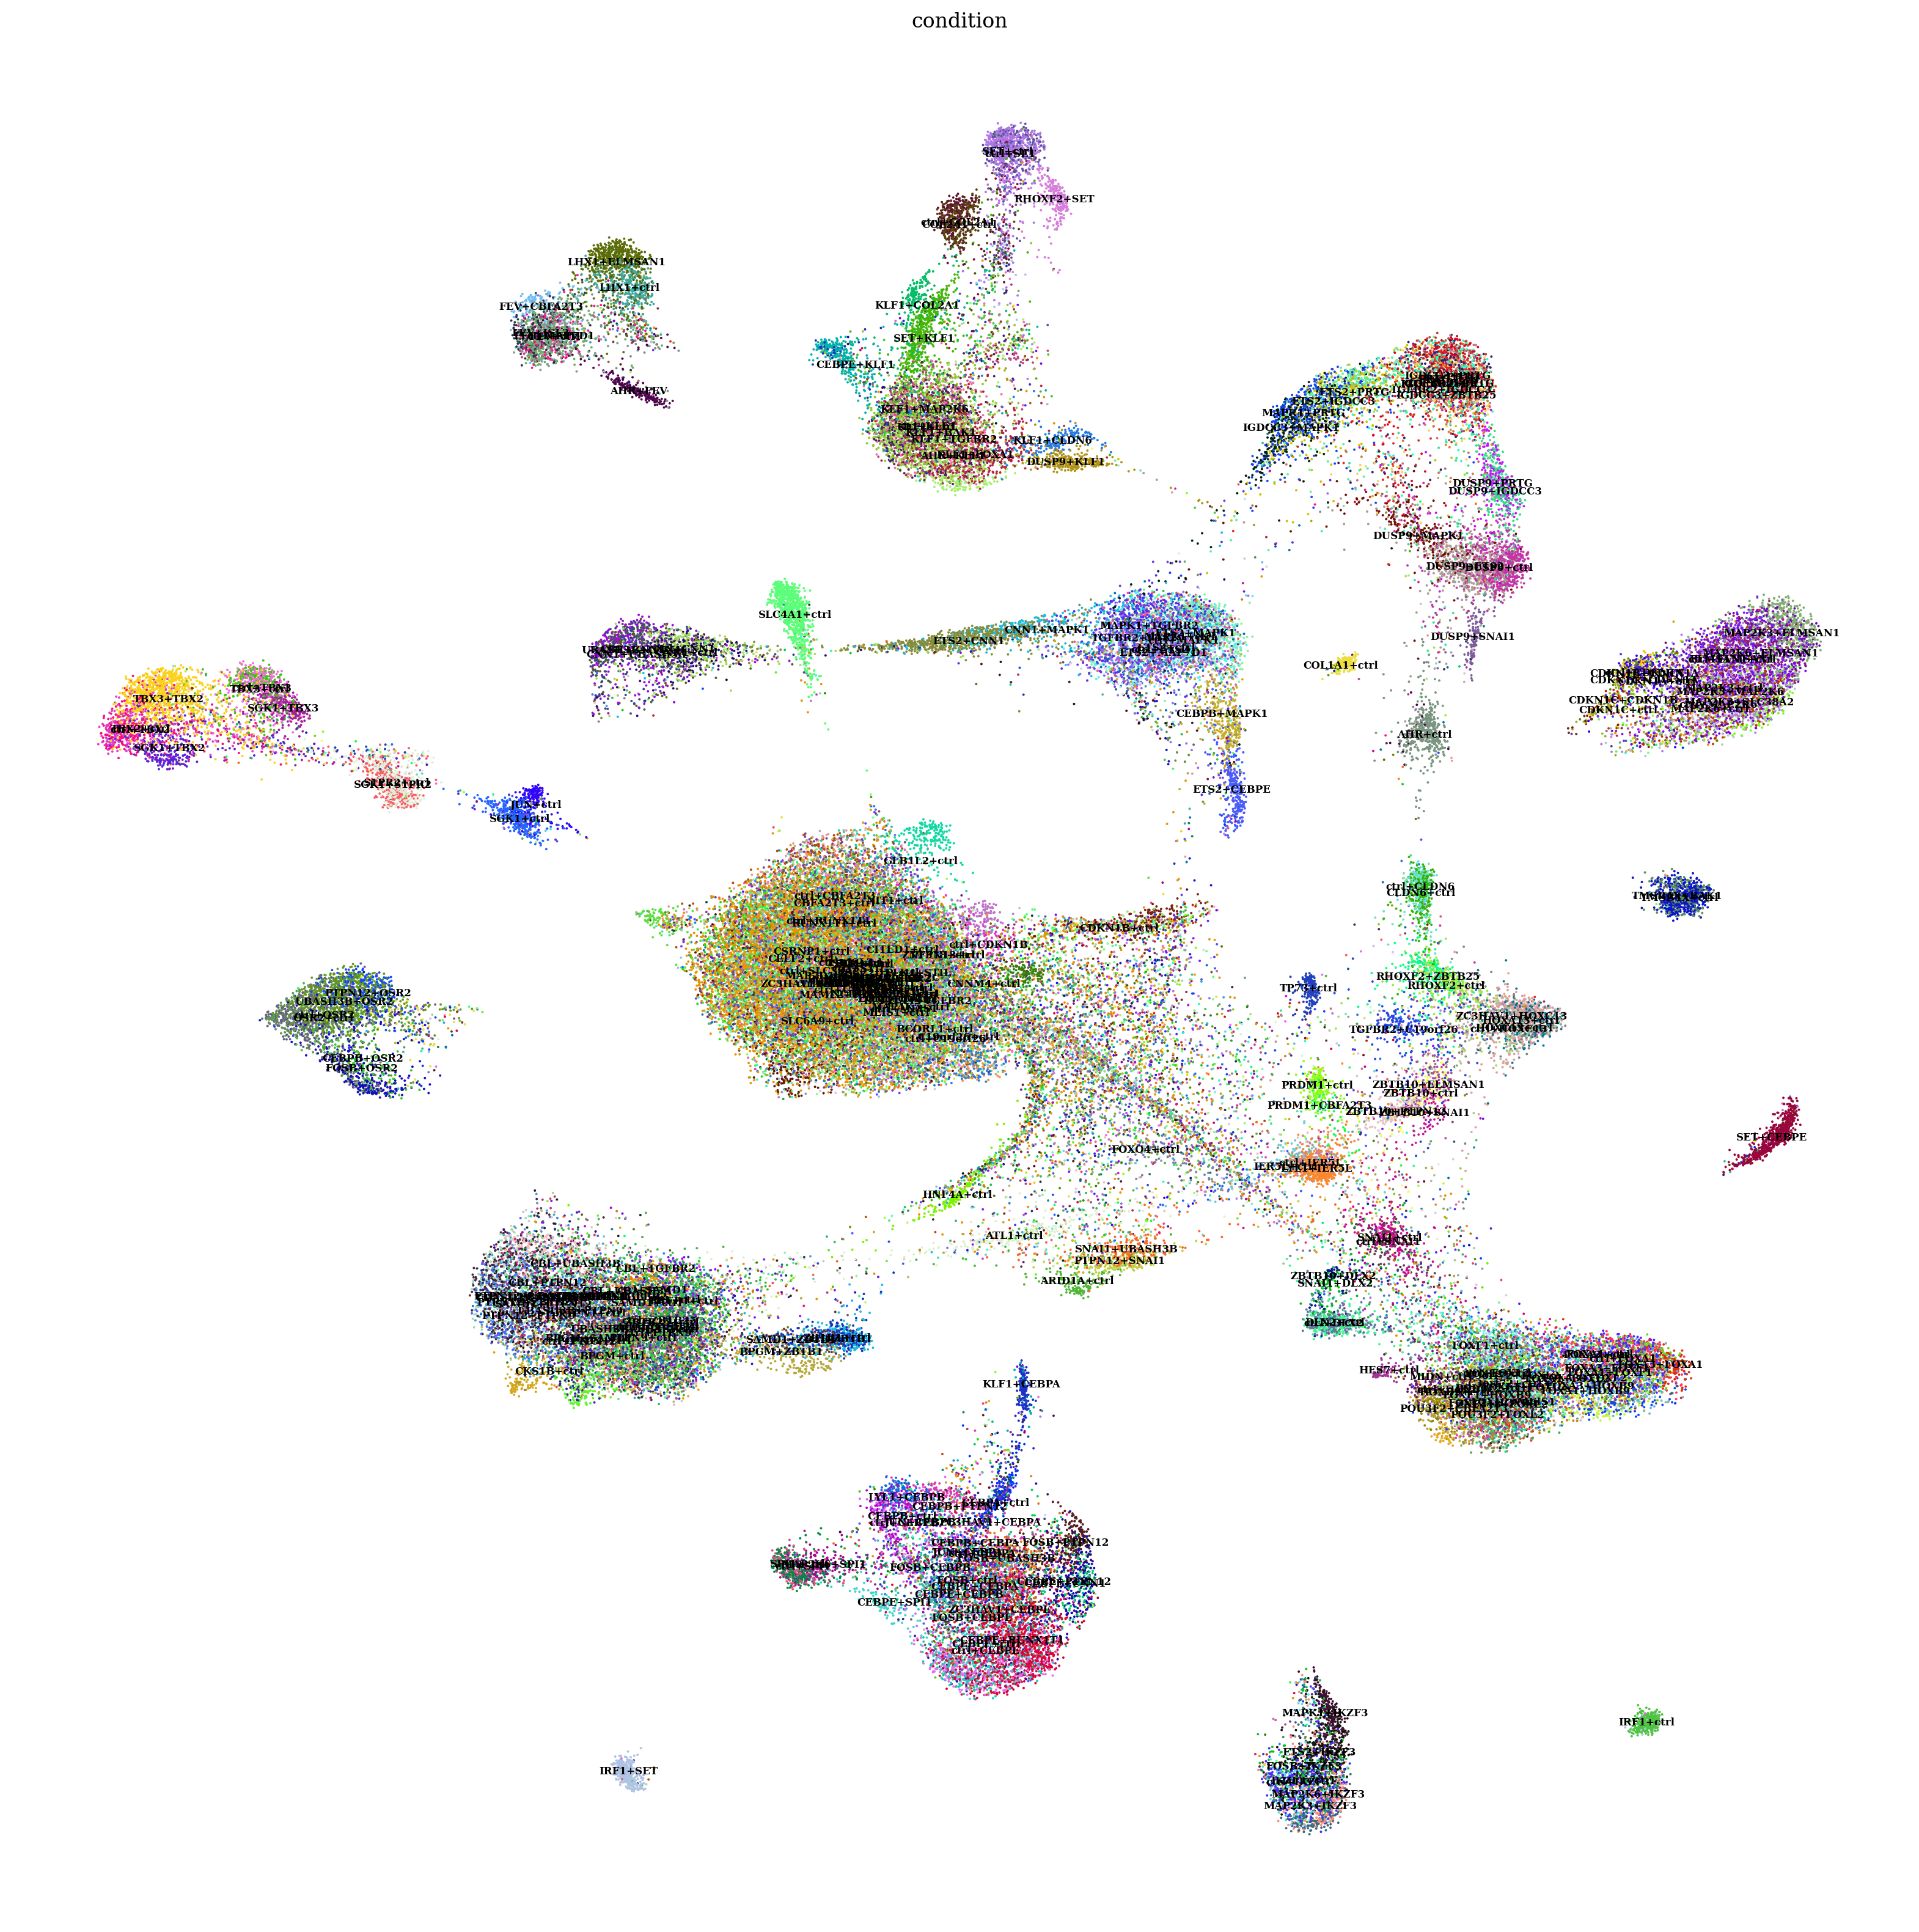

In [1142]:
def generate_random_colors(num_colors):
    return ["#"+''.join([np.random.choice(list('0123456789ABCDEF')) for j in range(6)]) for i in range(num_colors)]
unique_cell_types = latent.obs["condition"].unique()
random_colors = generate_random_colors(len(unique_cell_types))
color_map = dict(zip(unique_cell_types, random_colors))
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plt.figure(figsize=(20, 20))
    sc.pl.umap(
        latent, 
        color=["condition"], 
        ncols=1,
        size=8,
        frameon=False,
        palette=color_map,
        legend_loc="on data",
        legend_fontsize=6,
        legend_fontweight='bold',
        ax=plt.gca(),
    show=False
    )
plt.show()

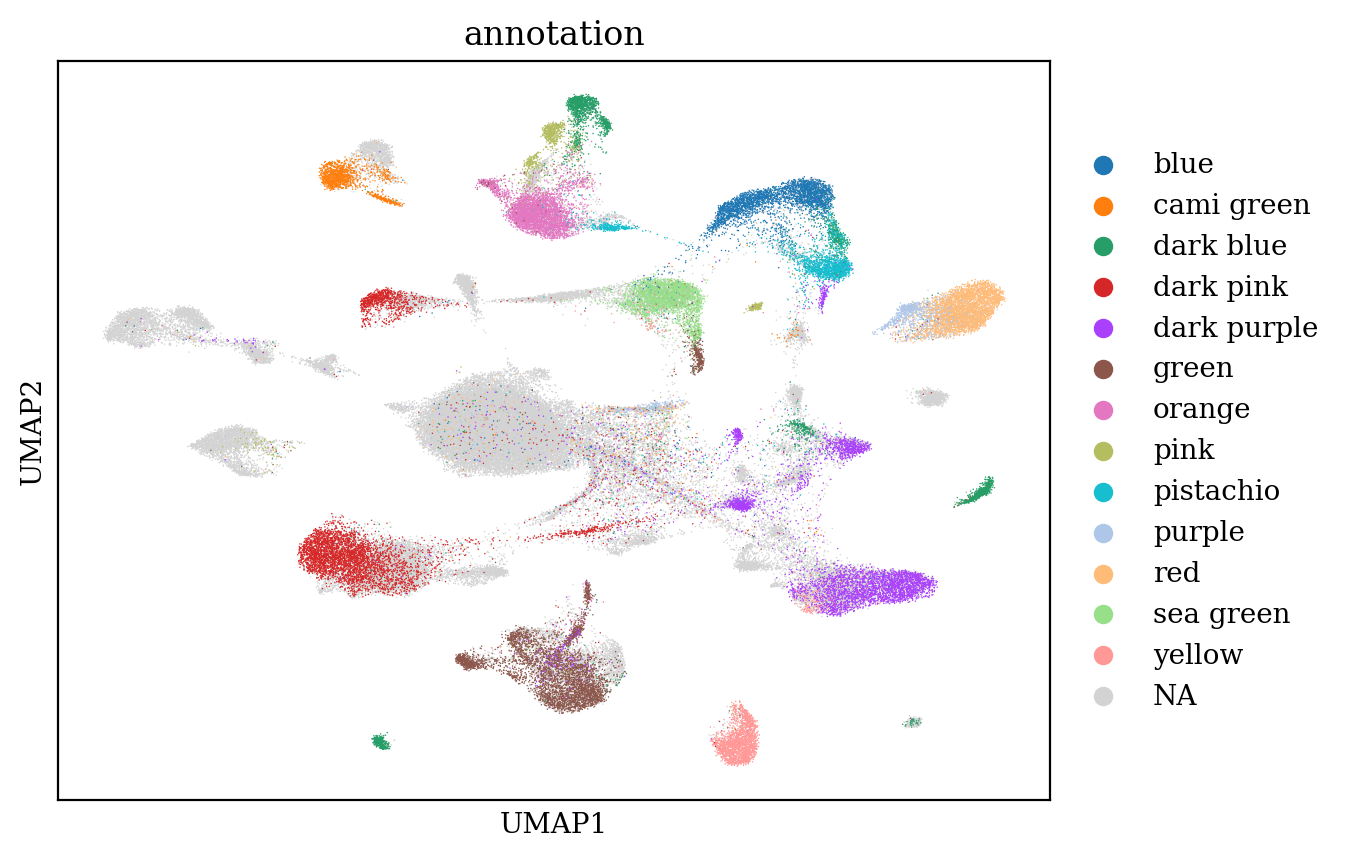

In [1143]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["annotation"], 
    )

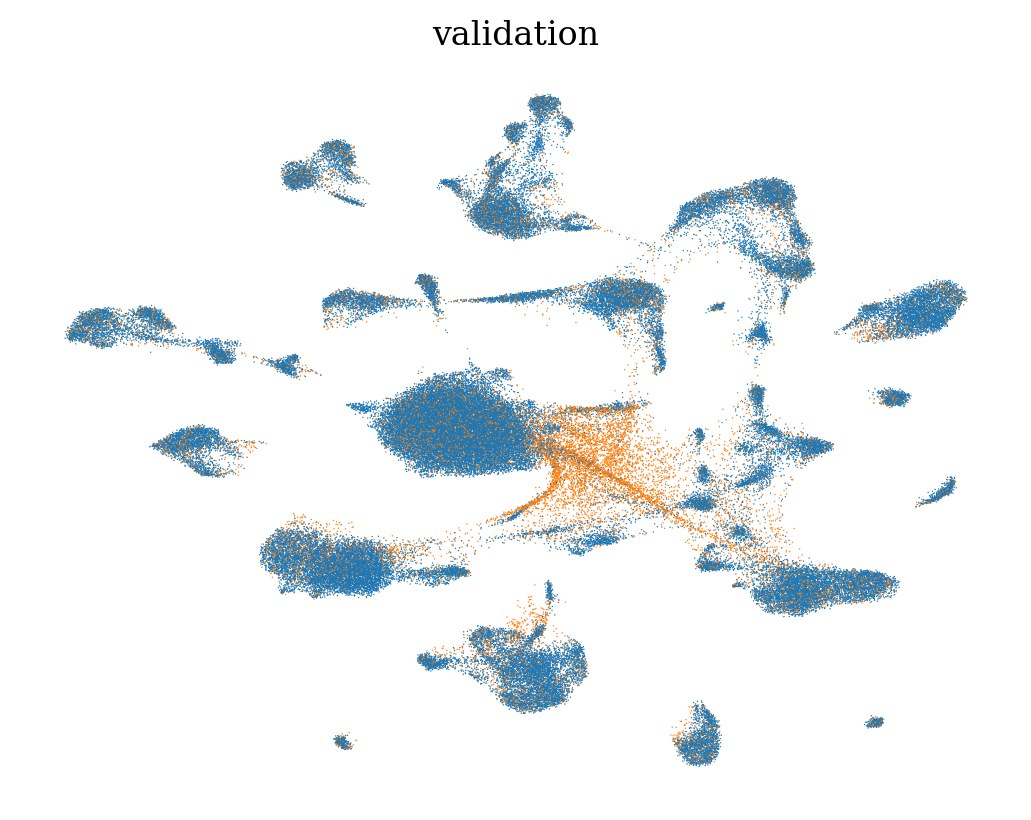

In [1164]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=["validation"], 
        ncols=1,
        size=1,
        frameon=False,
        legend_loc=None,
        legend_fontsize=6,
        legend_fontweight='bold'
    )

In [1165]:
def calculate_centroids_iqr(data, labels, multiplier=1.5):
    """
    Calculate centroids excluding outliers based on IQR.
    
    Parameters:
        data (np.array): The dataset (samples x features).
        labels (np.array): Condition labels corresponding to each sample in the data.
        multiplier (float): Multiplier for the IQR to define the confidence interval.
    
    Returns:
        dict: A dictionary containing the centroids for each unique condition.
    """
    unique_conditions = np.unique(labels)
    mean_centroids = dict()

    for condition in tqdm.tqdm(unique_conditions):
        condition_data = data[labels == condition]
        Q1 = np.percentile(condition_data, 25, axis=0)
        Q3 = np.percentile(condition_data, 75, axis=0)
        IQR = Q3 - Q1

        lower_bound = Q1 - multiplier * IQR
        upper_bound = Q3 + multiplier * IQR

        # Filtering out the outliers
        is_not_outlier = np.all((condition_data >= lower_bound) & (condition_data <= upper_bound), axis=1)
        filtered_data = condition_data[is_not_outlier]

        # Calculate the mean of the filtered data
        mean_centroids[condition] = np.mean(filtered_data, axis=0)

    return mean_centroids


In [1166]:
def calculate_centroids_median(data, labels):
    """
    Calculate centroids using the median to be robust against outliers.
    
    Parameters:
        data (np.array): The dataset (samples x features).
        labels (np.array): Condition labels corresponding to each sample in the data.
    
    Returns:
        dict: A dictionary containing the centroids for each unique condition based on the median.
    """
    unique_conditions = np.unique(labels)
    median_centroids = dict()

    for condition in tqdm.tqdm(unique_conditions):
        condition_data = data[labels == condition]
        # Computing the median across rows for this condition
        median_centroids[condition] = np.median(condition_data, axis=0)

    return median_centroids


In [1167]:
labels = latent.obs["condition"].to_numpy().flatten()
centroids_iqr = calculate_centroids_iqr(latent.X, labels=labels, multiplier = 1.0)
centroids_median = calculate_centroids_median(latent.X, labels=labels)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 284/284 [00:00<00:00, 458.98it/s]


In [1168]:
the_same = dict()
singles = set()
doubles = set()
singles_dict = dict()

for c in latent.obs["condition"].unique():
    if "+" not in c:
        assert c == "ctrl"
        k = ("ctrl", "ctrl")
    else:
        assert c.count("+") == 1
        k = tuple(sorted(c.split("+")))
            
    if k not in the_same:
        the_same[k] = []
    the_same[k].append(c)


    if "ctrl" in k:
        singles.add(k)
        i = list(k).index("ctrl")
        l = k[0] if i==1 else k[1]
        if l not in singles_dict:
            singles_dict[l] = []
        singles_dict[l].append(k)
    else:
        doubles.add(k)

In [1169]:
def ctrl_remover_single(asd):
    assert "ctrl" in asd
    k = tuple(sorted(asd.split("+")))
    i = list(k).index("ctrl")
    l = k[0] if i==1 else k[1]
    return l

In [1170]:
combinations = []
for d1, d2 in doubles:
    css = the_same[(d1, d2)]
    d1s = singles_dict[d1]
    d2s = singles_dict[d2]
    d1ss = {j for i in d1s for j in the_same[i]}
    d2ss = {j for i in d2s for j in the_same[i]}
    assert len(css) == 1
    css = css[0]
    combinations.append([css, list(d1ss), list(d2ss)])    

In [1171]:
centroids = centroids_iqr

vectors = dict()
for combin, perturb1, perturb2 in combinations:
    for perturb in [perturb1, perturb2]:
        for pertur in perturb:
            pertur_vector = centroids[pertur] - centroids["ctrl"]
            vectors[pertur] = pertur_vector
    combin_vector = centroids[combin] - centroids["ctrl"]
    vectors[combin] = combin_vector
for s in singles:
    for ss in the_same[s]:
        if ss not in vectors:
            vectors[ss] = centroids[ss] - centroids["ctrl"]

In [1172]:
sames = set()
for i in the_same:
    if len(the_same[i]) > 1:
        for j in the_same[i]:
            sames.add(j)

In [1173]:
singles_set = set()
for s in singles:
    for ss in the_same[s]:
        singles_set.add(ss)
singles_set = list(singles_set)

In [1174]:
singles_pairwise = []
for ind, ss1 in enumerate(singles_set):
    if ss1 == "ctrl":
        continue
    for ss2 in singles_set[ind:]:
        if ss2 == "ctrl":
            continue
        if ctrl_remover_single(ss1) != ctrl_remover_single(ss2):
            singles_pairwise.append(scipy.spatial.distance.euclidean(vectors[ss1], vectors[ss2]))

In [1175]:
len(singles_pairwise), len(singles_set)

(11429, 153)

In [1176]:
distance_singles_same = []
for k, v in the_same.items():
    if len(v) > 1:
        assert len(v) == 2
        ss1, ss2 = v
        distance_singles_same.append(scipy.spatial.distance.euclidean(vectors[ss1], vectors[ss2]))

In [1177]:
np.median(singles_pairwise), np.median(distance_singles_same)

(12.58853816986084, 0.24351318180561066)

In [1178]:
labels = len(singles_pairwise) * ["pairwise_distance"] + len(distance_singles_same) * ["the_same"]
values = singles_pairwise + distance_singles_same
df = pd.DataFrame([values, labels], index=["values", "labels"]).T

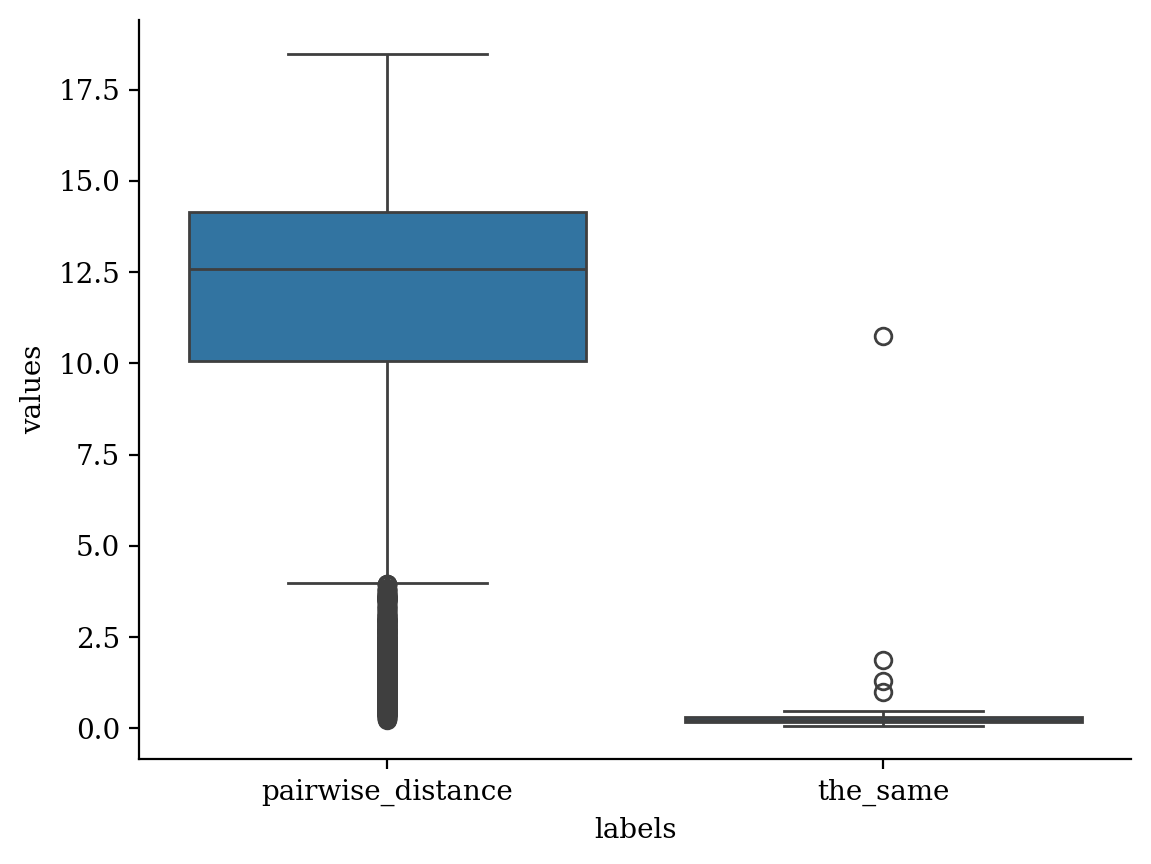

In [1179]:
sns.boxplot(df, x="labels", y="values")
sns.despine()

In [1180]:
combination_distance = []
for combin, perturb1, perturb2 in combinations:
    true_vector = vectors[combin]
    prediction_vector = vectors[perturb1[0]] + vectors[perturb2[0]]
    combination_distance.append(scipy.spatial.distance.euclidean(true_vector, prediction_vector))

In [1181]:
np.sum(np.array(combination_distance)<2)/ len(combination_distance), np.sum(np.array(singles_pairwise)<2)/ len(singles_pairwise)

(0.24427480916030533, 0.09677137107358474)

<Axes: ylabel='Density'>

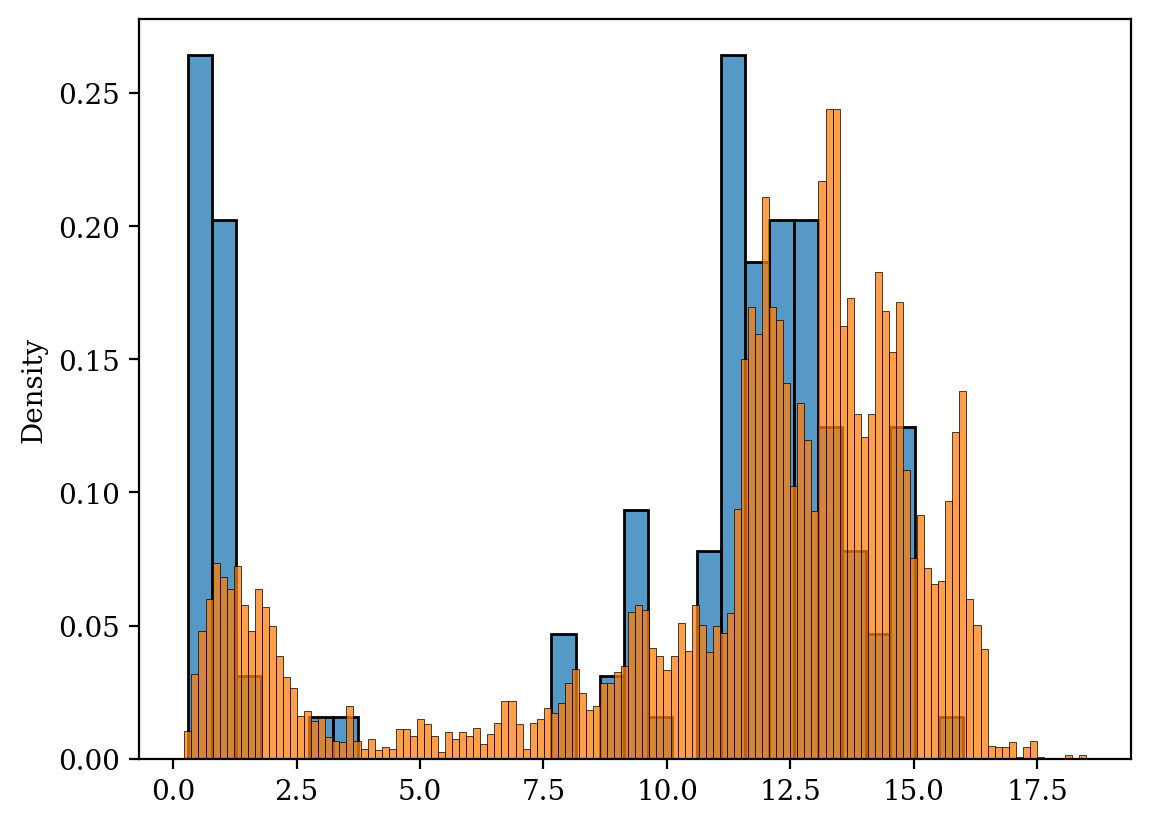

In [1182]:
sns.histplot(combination_distance, bins=32, stat="density")
sns.histplot(singles_pairwise, bins=128, stat="density")


<Axes: ylabel='Density'>

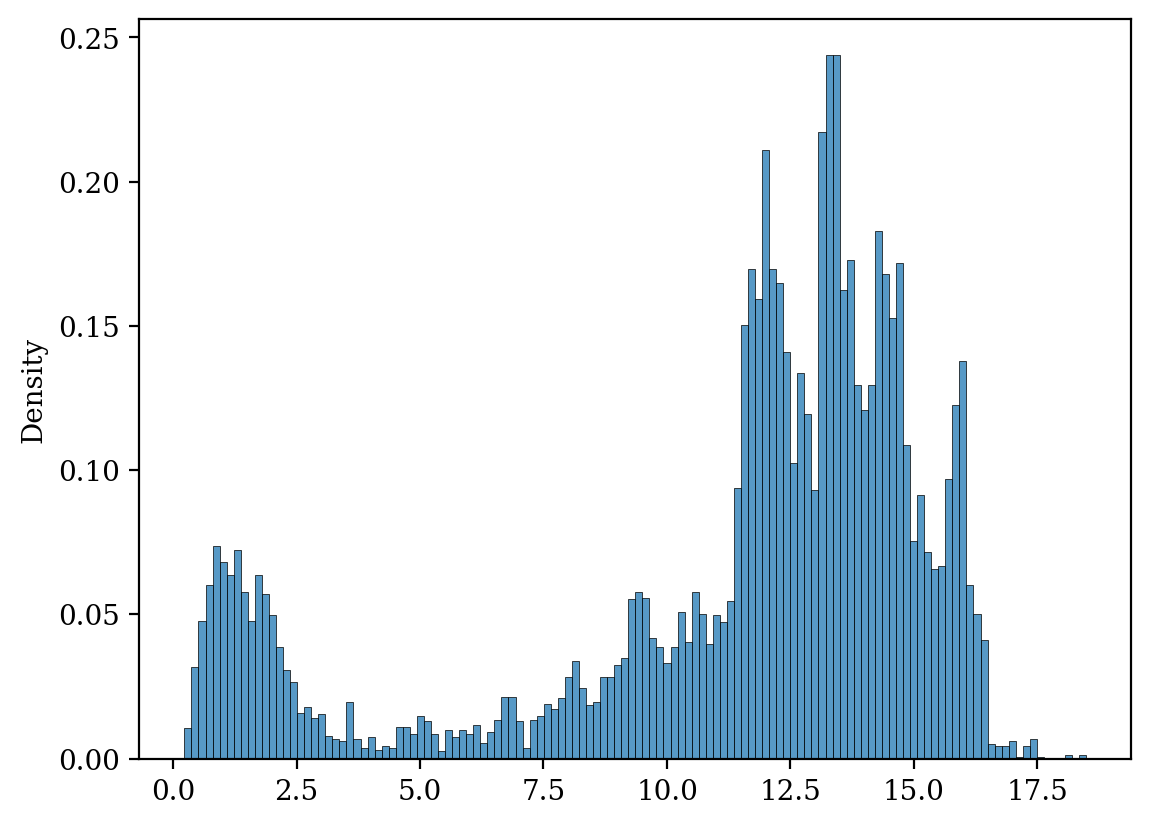

In [1183]:
sns.histplot(singles_pairwise, bins=128, stat="density")

cov_drug_dose_name dose_val  control      condition  \
index                                                                         
AAACCTGAGAAGAAGC-1             A549_ctrl_1        1        1           ctrl   
AAACCTGAGGCATGTG-1   A549_TSC22D1+ctrl_1+1      1+1        0   TSC22D1+ctrl   
AAACCTGAGGCCCTTG-1    A549_KLF1+MAP2K6_1+1      1+1        0    KLF1+MAP2K6   
AAACCTGCACGAAGCA-1             A549_ctrl_1        1        1           ctrl   
AAACCTGCAGACGTAG-1  A549_CEBPE+RUNX1T1_1+1      1+1        0  CEBPE+RUNX1T1   
...                                    ...      ...      ...            ...   
TTTGTCATCAGTACGT-8     A549_FOXA3+ctrl_1+1      1+1        0     FOXA3+ctrl   
TTTGTCATCCACTCCA-8     A549_CELF2+ctrl_1+1      1+1        0     CELF2+ctrl   
TTTGTCATCCCAACGG-8    A549_BCORL1+ctrl_1+1      1+1        0    BCORL1+ctrl   
TTTGTCATCCTCCTAG-8  A549_ZBTB10+PTPN12_1+1      1+1        0  ZBTB10+PTPN12   
TTTGTCATCTGGCGAC-8    A549_MAP4K3+ctrl_1+1      1+1        0    MAP4K3+ctrl   

                                            guide_identity     drug_dose_name  \
index                                                                           
AAACCTGAGAAGAAGC-1    NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0             ctrl_1   
AAACCTGAGGCATGTG-1      TSC22D1_NegCtrl0__TSC22D1_NegCtrl0   TSC22D1+ctrl_1+1   
AAACCTGAGGCCCTTG-1                KLF1_MAP2K6__KLF1_MAP2K6    KLF1+MAP2K6_1+1   
AAACCTGCACGAAGCA-1  NegCtrl10_NegCtrl0__NegCtrl10_NegCtrl0             ctrl_1   
AAACCTGCAGACGTAG-1            CEBPE_RUNX1T1__CEBPE_RUNX1T1  CEBPE+RUNX1T1_1+1   
...                                                    ...                ...   
TTTGTCATCAGTACGT-8          FOXA3_NegCtrl0__FOXA3_NegCtrl0     FOXA3+ctrl_1+1   
TTTGTCATCCACTCCA-8          CELF2_NegCtrl0__CELF2_NegCtrl0     CELF2+ctrl_1+1   
TTTGTCATCCCAACGG-8        BCORL1_NegCtrl0__BCORL1_NegCtrl0    BCORL1+ctrl_1+1   
TTTGTCATCCTCCTAG-8            ZBTB10_PTPN12__ZBTB10_PTPN12  ZBTB10+PTPN12_1+1   
TTTGTCATCTGGCGAC-8        MAP4K3_NegCtrl0__MAP4K3_NegCtrl0    MAP4K3+ctrl_1+1   

                   cell_type  split split1 split2  ... split20 split21  \
index                                              ...                   
AAACCTGAGAAGAAGC-1      A549  train  train  train  ...   train   train   
AAACCTGAGGCATGTG-1      A549  train  train  train  ...   train   train   
AAACCTGAGGCCCTTG-1      A549  train  train  train  ...     ood   train   
AAACCTGCACGAAGCA-1      A549  train   test  train  ...   train   train   
AAACCTGCAGACGTAG-1      A549  train  train  train  ...   train   train   
...                      ...    ...    ...    ...  ...     ...     ...   
TTTGTCATCAGTACGT-8      A549   test   test   test  ...   train   train   
TTTGTCATCCACTCCA-8      A549  train  train  train  ...   train   train   
TTTGTCATCCCAACGG-8      A549  train   test  train  ...   train   train   
TTTGTCATCCTCCTAG-8      A549  train  train  train  ...   train   train   
TTTGTCATCTGGCGAC-8      A549  train  train   test  ...    test    test   

                   split22 split23 split24 split25 _scvi_batch _scvi_labels  \
index                                                                         
AAACCTGAGAAGAAGC-1   train   train   train   train           0            0   
AAACCTGAGGCATGTG-1   train   train   train   train           0            0   
AAACCTGAGGCCCTTG-1   train     ood   train   train           0            0   
AAACCTGCACGAAGCA-1   train   train    test    test           0            0   
AAACCTGCAGACGTAG-1   train     ood   train   train           0            0   
...                    ...     ...     ...     ...         ...          ...   
TTTGTCATCAGTACGT-8    test   train   train   train           0            0   
TTTGTCATCCACTCCA-8   train   train   train   train           0            0   
TTTGTCATCCCAACGG-8   train   train   train   train           0            0   
TTTGTCATCCTCCTAG-8   train     ood   train   train           0            0   
TTTGTCATCTGGCGAC-8    test   tr

In [1189]:
baseline_adata = ad.read_h5ad("/home/icb/kemal.inecik/lustre_workspace/downloaded_data/norman_2019.h5ad")

In [1190]:
baseline_adata.obs

guide_identity  read_count  \
index                                                                    
AAACCTGAGAAGAAGC-1    NegCtrl0_NegCtrl0__NegCtrl0_NegCtrl0        1252   
AAACCTGAGGCATGTG-1      TSC22D1_NegCtrl0__TSC22D1_NegCtrl0        2151   
AAACCTGAGGCCCTTG-1                KLF1_MAP2K6__KLF1_MAP2K6        1037   
AAACCTGCACGAAGCA-1  NegCtrl10_NegCtrl0__NegCtrl10_NegCtrl0         958   
AAACCTGCAGACGTAG-1            CEBPE_RUNX1T1__CEBPE_RUNX1T1         244   
...                                                    ...         ...   
TTTGTCATCAGTACGT-8          FOXA3_NegCtrl0__FOXA3_NegCtrl0        2068   
TTTGTCATCCACTCCA-8          CELF2_NegCtrl0__CELF2_NegCtrl0         829   
TTTGTCATCCCAACGG-8        BCORL1_NegCtrl0__BCORL1_NegCtrl0         136   
TTTGTCATCCTCCTAG-8            ZBTB10_PTPN12__ZBTB10_PTPN12        1254   
TTTGTCATCTGGCGAC-8        MAP4K3_NegCtrl0__MAP4K3_NegCtrl0        1226   

                    UMI_count   coverage  gemgroup  good_coverage  \
index                                                               
AAACCTGAGAAGAAGC-1         67  18.686567         1           True   
AAACCTGAGGCATGTG-1        104  20.682692         1           True   
AAACCTGAGGCCCTTG-1         59  17.576271         1           True   
AAACCTGCACGAAGCA-1         39  24.564103         1           True   
AAACCTGCAGACGTAG-1         14  17.428571         1           True   
...                       ...        ...       ...            ...   
TTTGTCATCAGTACGT-8         95  21.768421         8           True   
TTTGTCATCCACTCCA-8         33  25.121212         8           True   
TTTGTCATCCCAACGG-8          9  15.111111         8           True   
TTTGTCATCCTCCTAG-8         59  21.254237         8           True   
TTTGTCATCTGGCGAC-8         59  20.779661         8           True   

                    number_of_cells  guide_AHR  guide_ARID1A  guide_ARRDC3  \
index                                                                        
AAACCTGAGAAGAAGC-1                2          0             0             0   
AAACCTGAGGCATGTG-1                1          0             0             0   
AAACCTGAGGCCCTTG-1                1          0             0             0   
AAACCTGCACGAAGCA-1                1          0             0             0   
AAACCTGCAGACGTAG-1                1          0             0             0   
...                             ...        ...           ...           ...   
TTTGTCATCAGTACGT-8                1          0             0             0   
TTTGTCATCCACTCCA-8                1          0             0             0   
TTTGTCATCCCAACGG-8                1          0             0             0   
TTTGTCATCCTCCTAG-8                3          0             0             0   
TTTGTCATCTGGCGAC-8                1          0             0             0   

                    ...  n_genes  n_genes_by_counts  total_counts  \
index               ...                                             
AAACCTGAGAAGAAGC-1  ...     4108               4108       19413.0   
AAACCTGAGGCATGTG-1  ...     3142               3142       13474.0   
AAACCTGAGGCCCTTG-1  ...     4229               4229       23228.0   
AAACCTGCACGAAGCA-1  ...     2114               2114        6842.0   
AAACCTGCAGACGTAG-1  ...     2753               2753        9130.0   
...                 ...      ...                ...           ...   
TTTGTCATCAGTACGT-8  ...     3305               3305       14727.0   
TTTGTCATCCACTCCA-8  ...     2842               2842        9750.0   
TTTGTCATCCCAACGG-8  ...     2824               2824        8670.0   
TTTGTCATCCTCCTAG-8  ...     5180               5179       29247.0   
TTTGTCATCTGGCGAC-8  ...     3058               3058       12514.0   

                    total_counts_mt  pct_counts_mt  leiden  perturbation_name  \
index                                                                           
AAACCTGAGAAGAAGC-1           1327.0       6.835625      10            control   
AAACCTGAGGCATGTG-1         

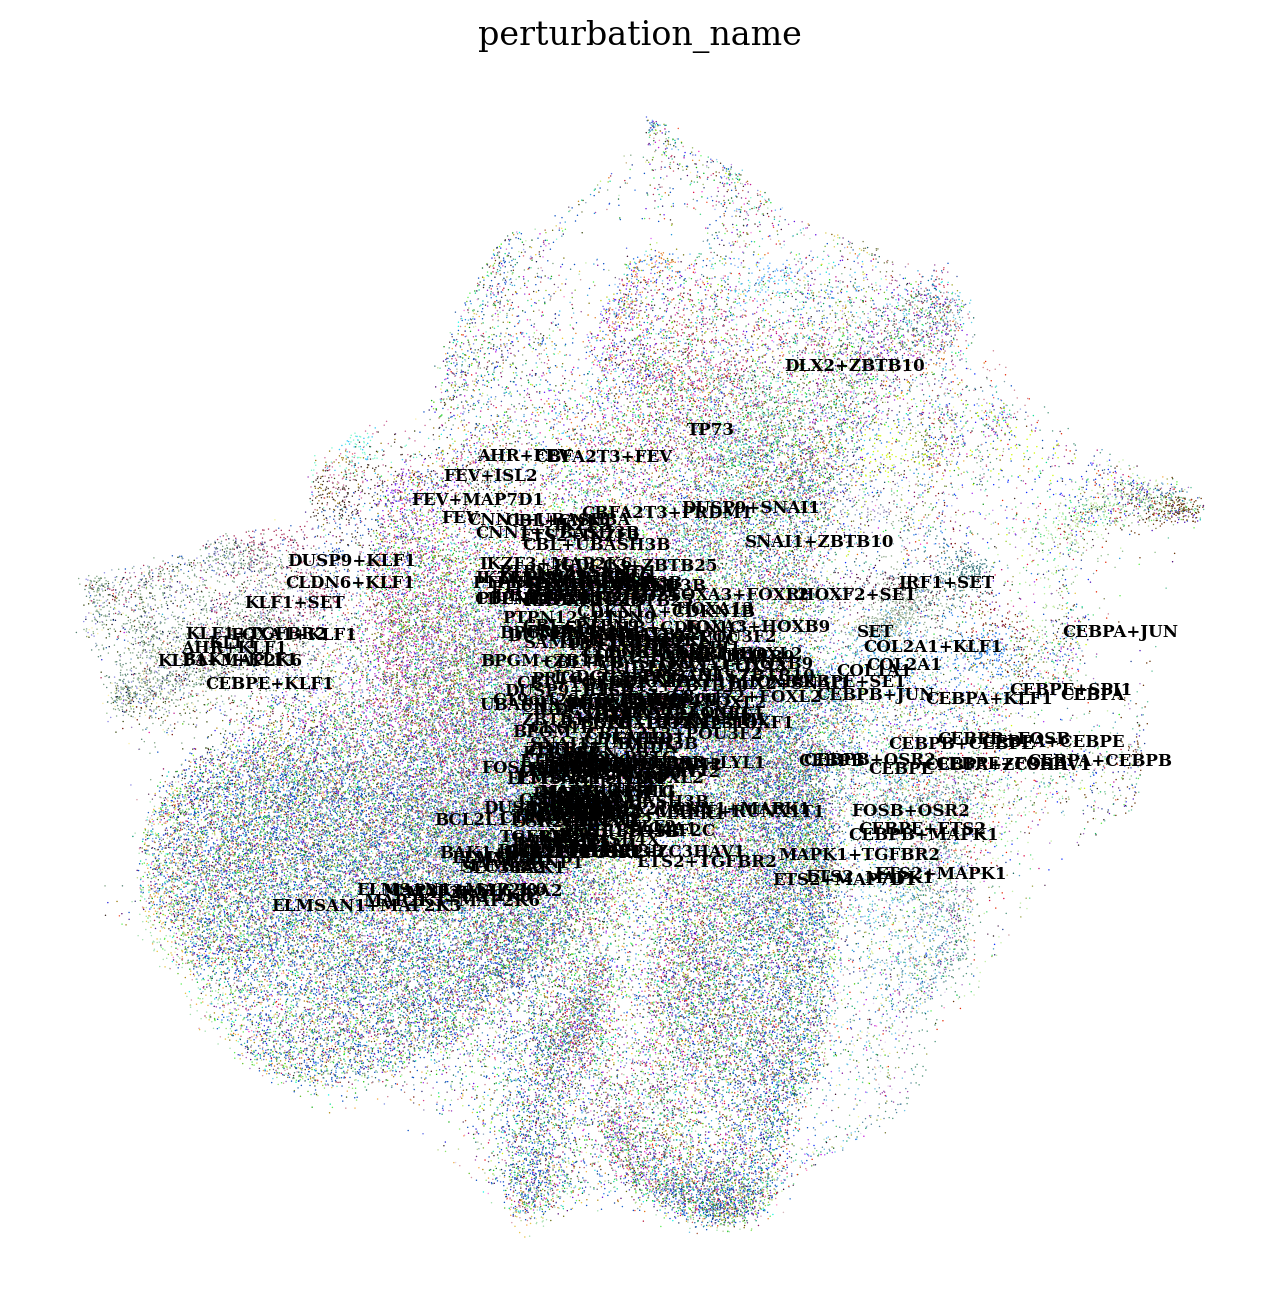

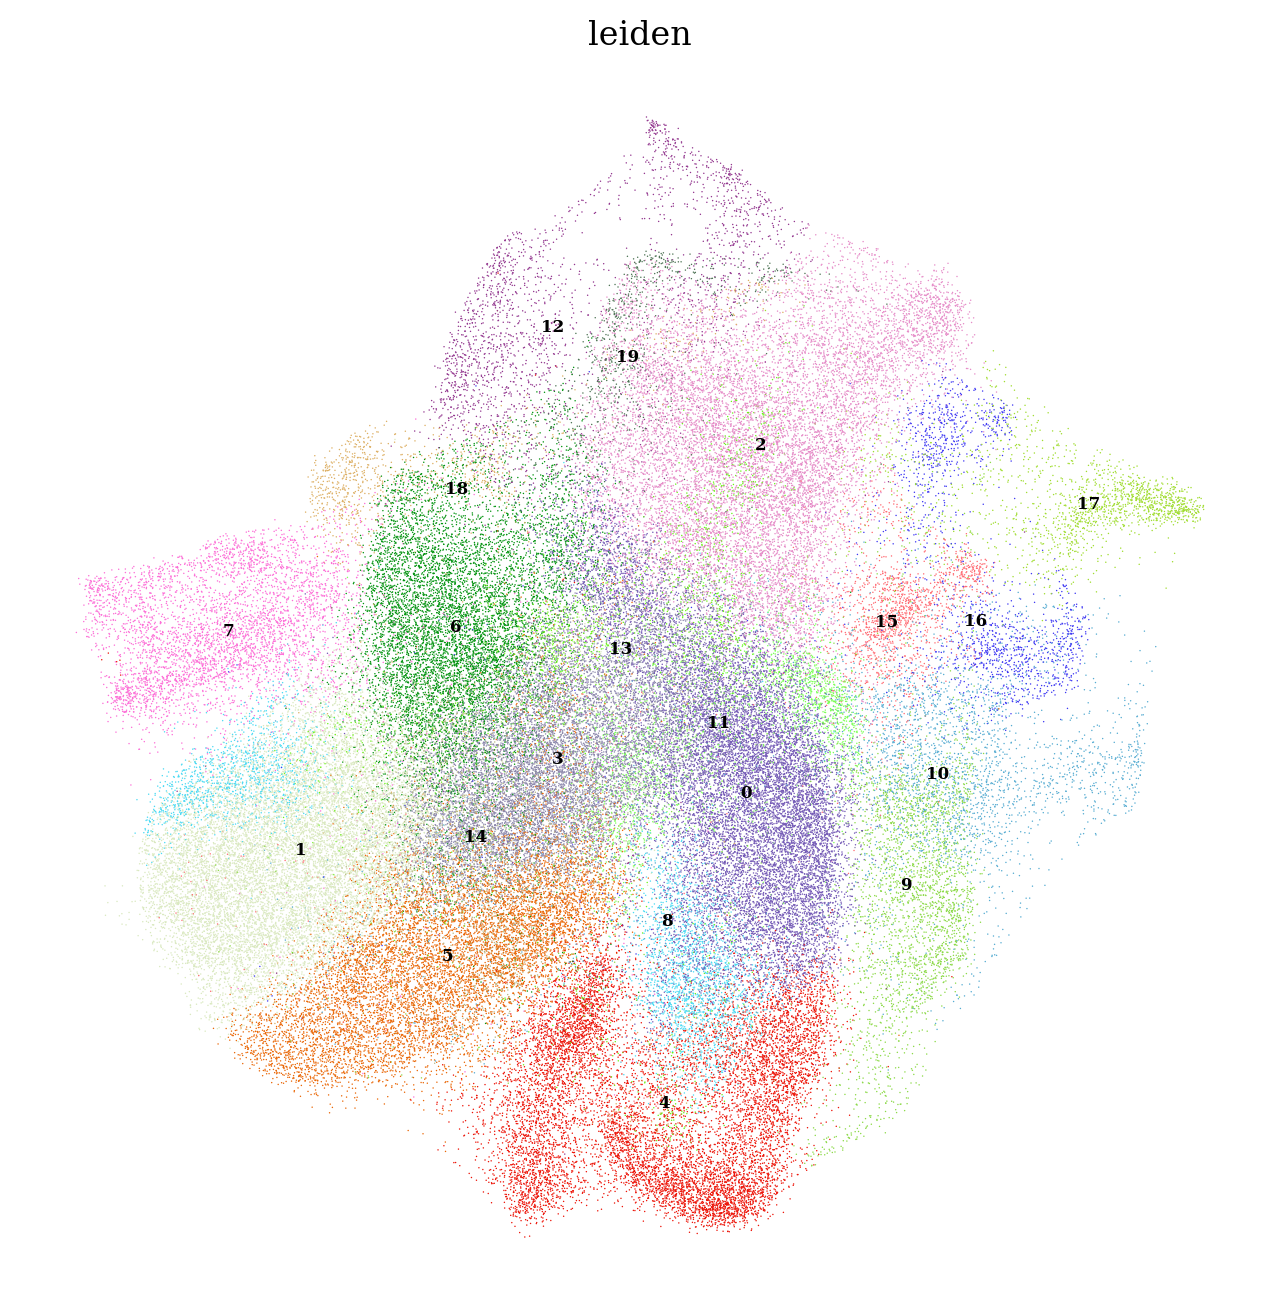

In [396]:
def generate_random_colors(num_colors):
    return ["#"+''.join([np.random.choice(list('0123456789ABCDEF')) for j in range(6)]) for i in range(num_colors)]
unique_cell_types = baseline_adata.obs["perturbation_name"].unique()
random_colors = generate_random_colors(len(unique_cell_types))
color_map = dict(zip(unique_cell_types, random_colors))
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plt.figure(figsize=(8, 8))
    sc.pl.umap(
        baseline_adata, 
        color=["perturbation_name"], 
        ncols=1,
        frameon=False,
        palette=color_map,
        legend_loc="on data",
        legend_fontsize=6,
        legend_fontweight='bold',
        ax=plt.gca(),
    show=False
    )
plt.show()

unique_cell_types = baseline_adata.obs["leiden"].unique()
random_colors = generate_random_colors(len(unique_cell_types))
color_map = dict(zip(unique_cell_types, random_colors))
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plt.figure(figsize=(8, 8))
    sc.pl.umap(
        baseline_adata, 
        color=["leiden"], 
        ncols=1,
        frameon=False,
        palette=color_map,
        legend_loc="on data",
        legend_fontsize=6,
        legend_fontweight='bold',
        ax=plt.gca(),
    show=False
    )
plt.show()

In [48]:
# resolution = 1.12345
# rsc.tl.leiden(latent, resolution=np.round(resolution, 3), key_added="leiden_" + format(resolution, ".3f"))